# Notebook 2 - Design of inhibitors against histamine H1 receptor

By Vincent Blay, November 2021

In this notebook, we demonstrate the use of MACAW embeddings to model binding affinity to a protein receptor of pharmacological interest. MACAW embeddings are then applied to identify promising candidate molecules in a custom virtual library.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.svm import SVR
from sklearn_rvm import EMRVR
from sklearn.metrics import r2_score

#Needed to show molecules
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole 

import sys
sys.path.append('../')

import macaw
print(macaw.__version__)
from macaw import *

%run "./plotting.py"

0.1.14


In [2]:
%config InlineBackend.figure_format = 'retina'

## 1. Binding to histamine H1 receptor

### 1.1 Data preparation

In [3]:
df = pd.read_csv("./data/data_H1.csv")
Y = df.pKi
smiles = df.Smiles
df.head()

,ID,compound_id,Smiles,pKi
0,1,CHEMBL3925977,O=C(O)c1ccc2cccnc2c1N1CCN(CCc2ccc(OCCCN3CCCCCC...,5.599999
1,2,CHEMBL2171045,O=C(NS(=O)(=O)c1cccc(C(F)(F)F)c1)N1CCC(N2CCC(O...,7.400008
2,3,CHEMBL3753784,COc1ccc(CNc2nc(N3CCN(C)CC3)nc3c2CCc2ccccc2-3)c...,5.200000
3,4,CHEMBL3917794,O=C(O)c1ccc2cccc(N3CCN(CCc4ccc(OCCCN5CCCCCC5)c...,6.599998
4,5,CHEMBL240394,O=C(c1cc(F)cc(F)c1)N1CCN(c2ccc(OCCCN3CCCCC3)cc...,5.700001


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


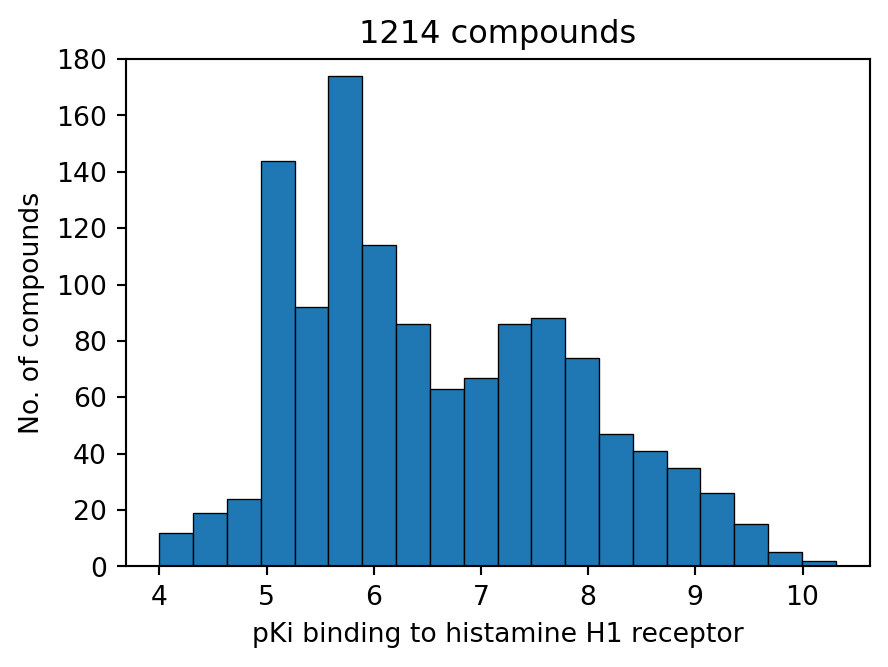

In [4]:
plot_histogram(Y, xlabel="pKi binding to histamine H1 receptor")

In [5]:
smi_train, smi_test, y_train, y_test = train_test_split(smiles, Y, test_size=0.2, random_state=42)

### 1.2 Compute MACAW embeddings

In [6]:
mcw = MACAW(type_fp='atompairs', metric='sokal', n_components=15, n_landmarks=200, random_state=39)
mcw.fit(smi_train, y_train)

In [7]:
X_train = mcw.transform(smi_train)
X_train.shape

(971, 15)

In [8]:
X_test = mcw.transform(smi_test)
X_test.shape

(243, 15)

### 1.3 Modeling using a SVR

In [9]:
for C in [1,3,5,7,10,30,50]:
    regr = SVR(kernel='rbf', C=C, epsilon=.1)
    scores = cross_val_score(regr, X_train, y_train, cv = 5)
    print(scores.mean())

0.72622091945669
0.7431390610059909
0.7442875763391095
0.7452071432541344
0.7446444353537112
0.7212851361961129
0.6906376895208776


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


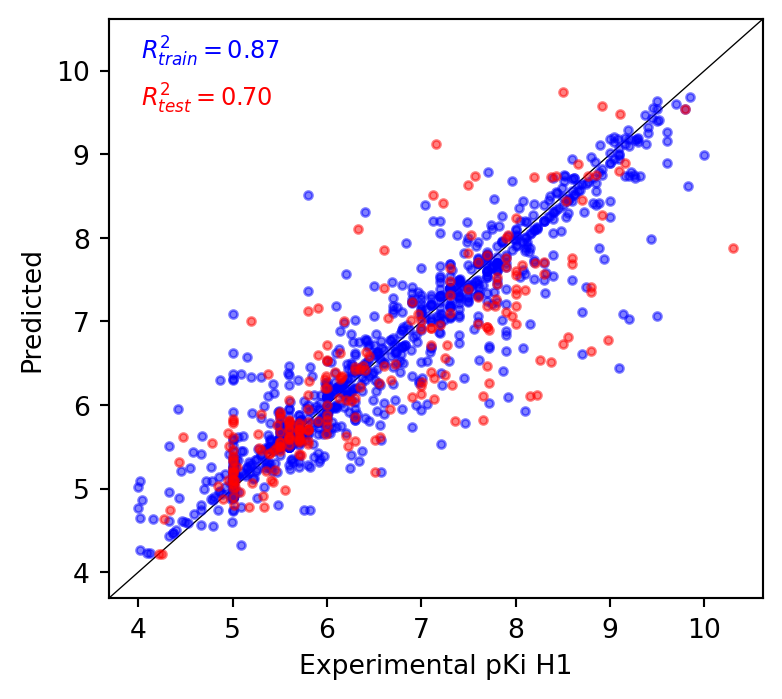

In [10]:
regr = SVR(kernel='rbf', C=7, epsilon=.1)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train,y=y_train_pred,x_test=y_test,y_test=y_test_pred, 
            xlabel="Experimental pKi H1", savetitle="./results/macaw/H1_SVR.svg")

Generate a model trained on the whole data set, to be used for prediction tasks

In [11]:
mcw = MACAW(type_fp='atompairs', metric='sokal', n_components=15, n_landmarks=200, random_state=39)
mcw.fit(smiles, Y)

In [12]:
X_all = mcw.transform(smiles)
X_all.shape

(1214, 15)

In [13]:
regr_pred = SVR(kernel='rbf', C=7, epsilon=.1)
regr_pred.fit(X_all, Y)

# Train set predictions
y_pred = regr_pred.predict(X_all)

print(f"R^2 = {r2_score(y_pred, Y):0.2f}")

R^2 = 0.86


## 2. Binding to muscarinic receptor M2

### 2.1 Data preparation

In [14]:
df = pd.read_csv("./data/data_M2.csv")
Y = df.pKi
smiles = df.Smiles
df.head()

,ID,compound_id,Smiles,pKi
0,1,CHEMBL358493,C[N+]12CCC(CC1)C(O)(c1cc3ccccc3o1)C2,5.259637
1,2,CHEMBL343236,c1ccc2c(c1)CC(C1CN3CCC1CC3)O2,6.309894
2,3,CHEMBL150845,CC(=C1CCN(C2CCN(C(=O)c3ccc(F)c4ccccc34)CC2)CC1...,8.017729
3,4,CHEMBL593871,C[C@H]1OC[C@@H](C[N+](C)(C)C)O[C@@H]1C,4.780000
4,5,CHEMBL91404,CCOC(=O)N1CCC(N2CCC(C(=O)c3ccc(S(=O)(=O)c4ccc5...,9.886057


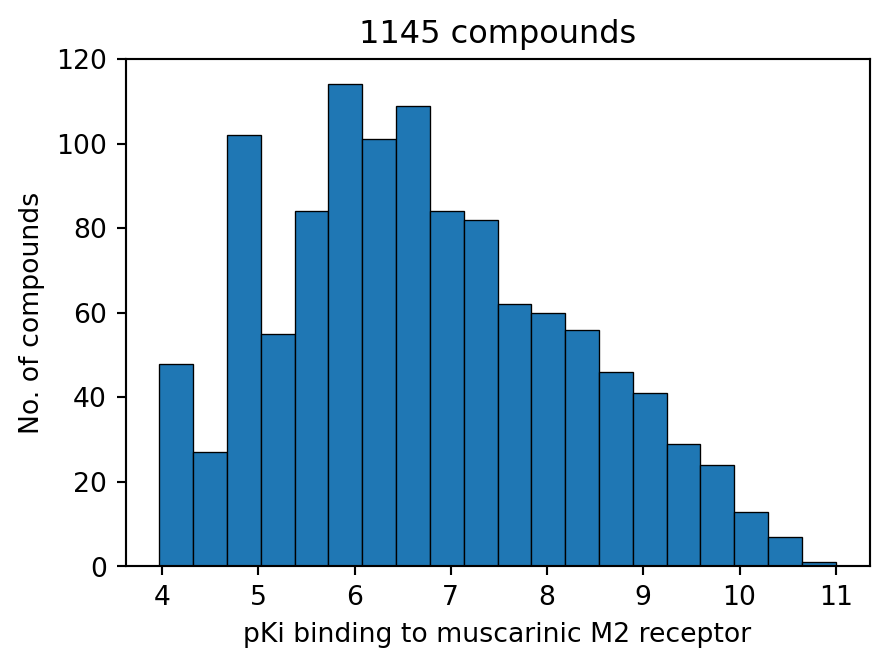

In [15]:
plot_histogram(Y, xlabel="pKi binding to muscarinic M2 receptor")

In [16]:
smi_train, smi_test, y_train, y_test = train_test_split(smiles, Y, test_size = 0.2, random_state = 42)

In [17]:
len(smi_train)

916

### 2.2 Compute MACAW embeddings

In [18]:
mcw2 = MACAW_optimus(smi_train, y=y_train, C=5, verbose=True, n_landmarks=200, exhaustiveness=1, random_state=41)

Problem type identified as regression
morgan2 & tanimoto: 0.578
morgan3 & tanimoto: 0.569
rdk5 & tanimoto: 0.616
rdk7 & tanimoto: 0.567
featmorgan2 & tanimoto: 0.564
featmorgan3 & tanimoto: 0.521
maccs & tanimoto: 0.591
avalon & tanimoto: 0.614
atompairs & tanimoto: 0.661
torsion & tanimoto: 0.609
pattern & tanimoto: 0.602
secfp6 & tanimoto: 0.528
layered & tanimoto: 0.631
atompairs & tanimoto: 0.661
atompairs & cosine: 0.669
atompairs & dice: 0.665
atompairs & sokal: 0.638
atompairs & kulczynski: 0.662
atompairs & mcconnaughey: 0.662
atompairs & braun-blanquet: 0.640
atompairs & rogot-goldberg: 0.670
atompairs & asymmetric: 0.628
atompairs & manhattan: 0.631
atompairs & blay-roger: 0.632
Setting recommended combination: atompairs & rogot-goldberg


In [19]:
X_train = mcw2.transform(smi_train)
print(X_train.shape)

X_test = mcw2.transform(smi_test)
print(X_test.shape)

(916, 15)
(229, 15)


### 2.3 Modeling using a SVR

In [20]:
for C in [1,3,5,10,30]:
    regr2 = SVR(kernel='rbf', C=C, epsilon=.3)
 
    scores = cross_val_score(regr2, X_train, y_train, cv=5)
    print(scores.mean())

0.676140295361033
0.706432195705893
0.7115620471428993
0.7018016669678022
0.6681053084929941


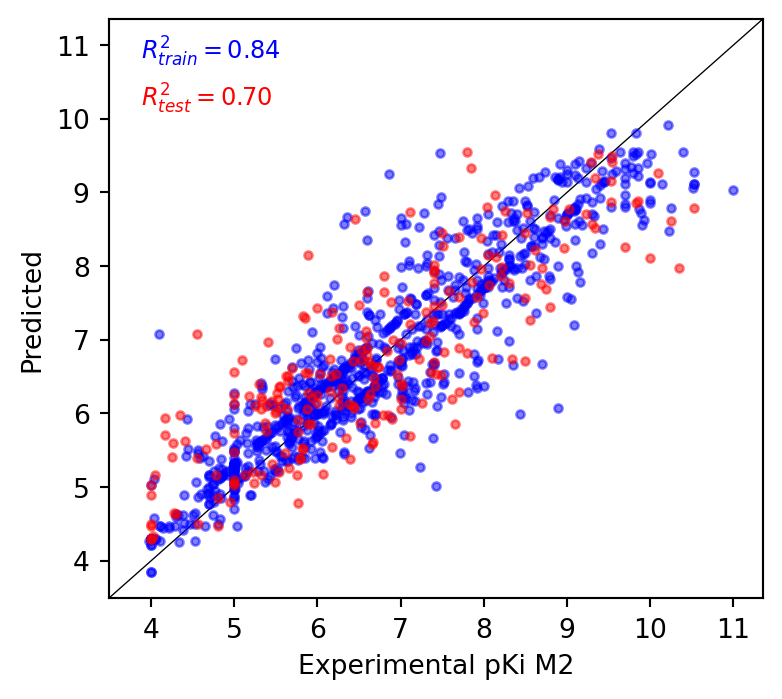

In [21]:
regr2 = SVR(kernel='rbf', C=5, epsilon=.3)
regr2.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr2.predict(X_train)

# Test set predictions
y_test_pred = regr2.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred, 
            xlabel="Experimental pKi M2", savetitle="./results/macaw/M2_SVR.svg")

Generate a model trained on the whole data set, to be used for prediction tasks

In [22]:
mcw2 = MACAW_optimus(smiles, y=Y, C=5, verbose=True, n_landmarks=200, exhaustiveness=1, random_state=41)


Problem type identified as regression
morgan2 & tanimoto: 0.617
morgan3 & tanimoto: 0.603
rdk5 & tanimoto: 0.528
rdk7 & tanimoto: 0.546
featmorgan2 & tanimoto: 0.476
featmorgan3 & tanimoto: 0.519
maccs & tanimoto: 0.487
avalon & tanimoto: 0.546
atompairs & tanimoto: 0.567
torsion & tanimoto: 0.590
pattern & tanimoto: 0.526
secfp6 & tanimoto: 0.526
layered & tanimoto: 0.537
morgan2 & tanimoto: 0.617
morgan2 & cosine: 0.628
morgan2 & dice: 0.635
morgan2 & sokal: 0.600
morgan2 & kulczynski: 0.628
morgan2 & mcconnaughey: 0.628
morgan2 & braun-blanquet: 0.638
morgan2 & rogot-goldberg: 0.635
morgan2 & asymmetric: 0.651
morgan2 & manhattan: 0.575
morgan2 & blay-roger: 0.589
Setting recommended combination: morgan2 & asymmetric


In [23]:
X_all = mcw2.transform(smiles)
X_all.shape

(1145, 15)

In [24]:
regr2_pred = SVR(kernel='rbf', C=5, epsilon=.3)
regr2_pred.fit(X_all, Y)

# Train set predictions
y_pred = regr2_pred.predict(X_all)

print(f"R^2 = {r2_score(y_pred, Y):0.2f}")

R^2 = 0.79


## 3. Discovery of new hits specific to H1

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` and `regr2` above, which use 15-D MACAW embeddings as their input. The custom library ("LibraryVB.csv") is a custom library compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted binding affinity to the H1 receptor and comparatively low predicted binding affinity to the M2 receptor.

In [25]:
mylib = pd.read_csv("./data/LibraryVB.csv")
print(mylib.shape)
mylib.head()

(19490, 2)


,Smiles,Source
0,NC(=O)NC(=O)Cn1c(=O)c(C#N)cn(C2CC2)c1=O,Enamine_antivirals
1,CC(C)CNC(=O)Cn1c(=O)c(C#N)cn(C2CC2)c1=O,Enamine_antivirals
2,O=C(Cn1cccnc1=O)NC1CCCCCC1,Enamine_antivirals
3,CCC(=O)Nc1ccc(cn1)N1CCOCC1,Enamine_antivirals
4,Cc1nn(C)c(C)c1CC(=O)NC(C1CC1)C1CC1,Enamine_antivirals


In [26]:
smi_lib = mylib.Smiles

Generate predictions for the H1 receptor:

In [27]:
X1_lib = mcw.transform(smi_lib)

Y1_lib_pred = regr_pred.predict(X1_lib)

Generate predictions for the M2 receptor:

In [28]:
X2_lib = mcw2.transform(smi_lib)

Y2_lib_pred = regr2_pred.predict(X2_lib)

Let us represent the predictions of both models:

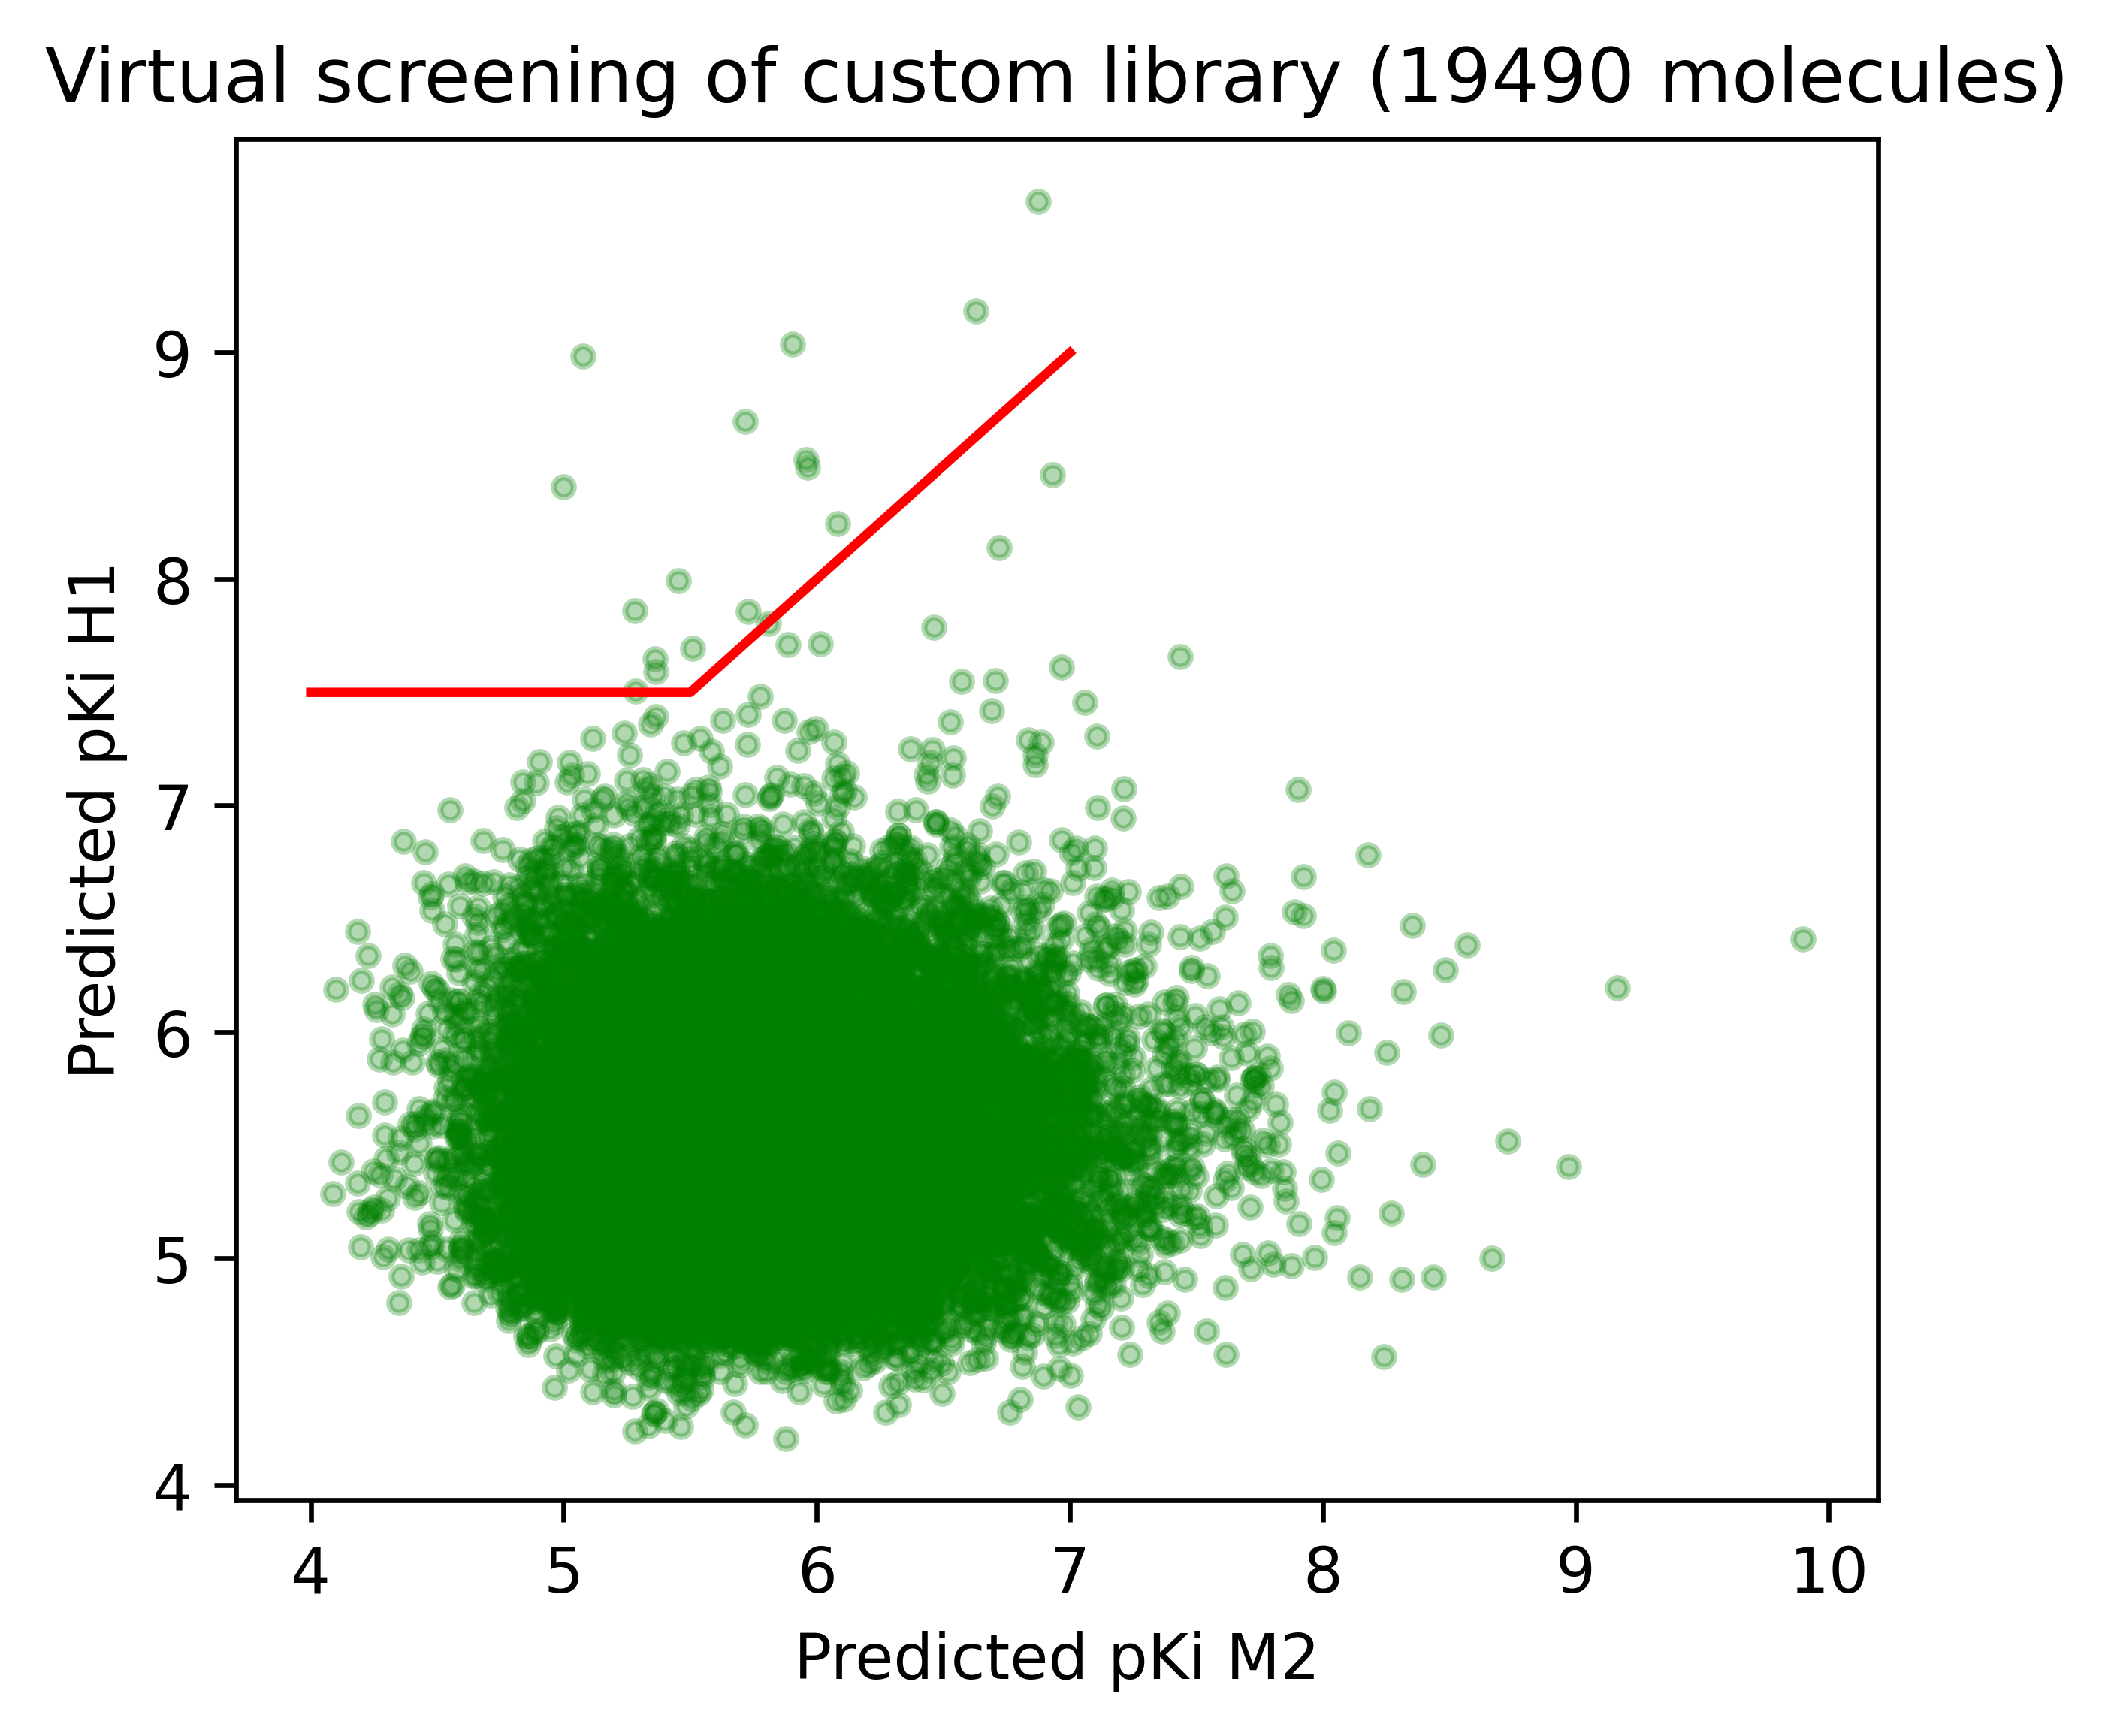

In [29]:
plt.figure(figsize=(4.7,4.0), dpi=300)
plt.scatter(x=Y2_lib_pred, y=Y1_lib_pred, s=10, c='green', alpha=0.3) 
plt.xlabel("Predicted pKi M2")
plt.ylabel("Predicted pKi H1")
plt.title(f"Virtual screening of custom library ({len(smi_lib)} molecules)")
plt.plot([4,5.5,7],[7.5,7.5,9],c='red')
plt.savefig("./results/macaw/H1_library_screening.svg", bbox_inches='tight', dpi=300)

Let us have a look at the compounds:

In [30]:
idx = np.where((Y1_lib_pred > 7.5)*(Y1_lib_pred > (Y2_lib_pred + 2.)))[0]

In [31]:
lead_df = mylib.iloc[idx].copy()
lead_df['pKi_H1_pred'] = Y1_lib_pred[idx]
lead_df['pKi_M2_pred'] = Y2_lib_pred[idx]

lead_df

,Smiles,Source,pKi_H1_pred,pKi_M2_pred
13904,Cc1ccc(cc1)/C(=C\CN1CCCC1)/c1ccccn1,Enamine_Phenotypic,7.859000,5.280388
13946,CN(C)CC/C=C\1/c2ccccc2COc2ccccc12,Enamine_Phenotypic,9.669416,6.874241
14440,OCCN1C(=O)c2cccc3c(ccc(C1=O)c23)N1CCCCC1,Enamine_Phenotypic,7.695111,5.510387
14508,CN(C)CCOC(c1ccc(Cl)cc1)c1ccccn1,Enamine_Phenotypic,8.492919,5.964938
14673,CN(C)CCN(Cc1ccccc1)c1ccccn1,Enamine_Phenotypic,8.408668,4.999995
14978,CN(C)CC[C@@H](c1ccc(Cl)cc1)c1ccccn1,Enamine_Phenotypic,9.036825,5.904298
15364,CN1CCN2C(C1)c1ccccc1Cc1cccnc21,Enamine_Phenotypic,8.695521,5.716629
15419,CN1CCc2c(C1)c1ccccc1n2Cc1ccccc1,Enamine_Phenotypic,7.504576,5.284223
15938,CN1CCC(=CC1)c1c[nH]c2ccccc12,Enamine_Phenotypic,7.993481,5.452868
17743,C(c1ccccc1)n1c(nc2ccccc12)N1CCNCC1,Enamine_Phenotypic,8.985401,5.076315


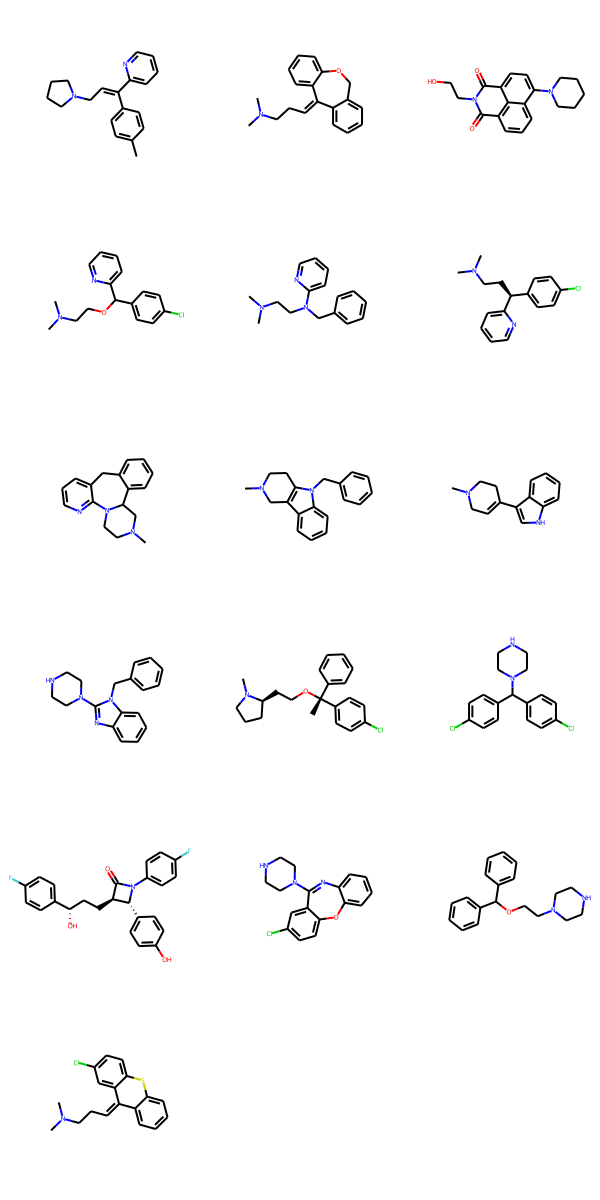

In [32]:
molecules = [Chem.MolFromSmiles(smi) for smi in lead_df.Smiles[:50]]

Draw.MolsToGridImage(molecules, subImgSize=(200,200), molsPerRow=3, useSVG=True)